# Train lstm1 model for phishing URL detection

## Imports

In [1]:
import numpy as np
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

import tensorflow_text as tf_text

In [2]:
dataset_dir = pathlib.Path("../URL_dataset/")
model_dir = pathlib.Path('../URL_models/')
checkpoint_dir = pathlib.Path('../URL_checkpoints/')

In [3]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-08-19_20;05;32.036830


In [4]:
os.listdir(dataset_dir)

['benign', 'phishing']

## Params

In [5]:
model_name = "lstm1"
batch_size = 16
rest_split_ratio = 0.2
test_split_ratio = 0.2

unicode_max = 1114111

## Load dataset

In [6]:
train_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 36275 files for training.


In [7]:
rest_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 9068 files for validation.


In [8]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

567


In [9]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio // batch_size))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio // batch_size))

In [10]:
class_names = train_ds.class_names

In [11]:
class_names

['benign', 'phishing']

## Explore dataset

In [12]:
b = train_ds.take(1)

In [13]:
b

<TakeDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float32)>

In [14]:
for d, label in b:
    print(label, d)

tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]], shape=(16, 1), dtype=float32) tf.Tensor(
[b'http://olx.ro/i2/electronice-si-electrocasnice/telefoane-mobile/telefoane-fixe-fax/gtm.js'
 b'http://guldmakind.prv.pl/?subtopic=signup'
 b'http://searchengineland.com/google-overtakes-traditonal-media-become-trusted-source-news-online-213176'
 b'http://censor.net.ua/resonance/330659/aleksandr_yaroslavskiyi_kogda_klub_vozglavlyaet_kloun_vse_mojet_byt'
 b'http://irecommend.ru/content/koftochka-aliexpress-free-shipping-2015-male-child-letter-urban-cotton-white-hood-sweatshirt'
 b'http://appleid.apple.co.uk.cgi-bin.webobjects.myappleid.woa.verify2.eu-id3.net/identify-customer=r3cZu4QGsRB0bu4pyomoXlEZkQrwQUYKbPz7Ye2MeaiqBiLntI6nwEXLuMkoxYikZcRPrRR5faT6rYz726zg9a7ePsToDpxRa8xj/'
 b'http://1337x.to/torrent/1160325/White-Noise-Meditation-10-Hz-Alpha-Ocean-Wave-Extended-Version-FLAC/'
 b'http://tunein.com/radio/CJRI-FM-1045-s95982/15480783/ca-

## Standarize the dataset

In [15]:
# No standarization for now

# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Vectorize

Cannot use the vectorization layers since it is not supported in TFJS; we can rather have a custom tokenizer which can be then exported as json then loaded in JS

In [16]:
tokenizer = tf_text.UnicodeCharTokenizer()

In [17]:
tokenizer.tokenize(d)

<tf.RaggedTensor [[104, 116, 116, 112, 58, 47, 47, 111, 108, 120, 46, 114, 111, 47, 105, 50, 47, 101, 108, 101, 99, 116, 114, 111, 110, 105, 99, 101, 45, 115, 105, 45, 101, 108, 101, 99, 116, 114, 111, 99, 97, 115, 110, 105, 99, 101, 47, 116, 101, 108, 101, 102, 111, 97, 110, 101, 45, 109, 111, 98, 105, 108, 101, 47, 116, 101, 108, 101, 102, 111, 97, 110, 101, 45, 102, 105, 120, 101, 45, 102, 97, 120, 47, 103, 116, 109, 46, 106, 115], [104, 116, 116, 112, 58, 47, 47, 103, 117, 108, 100, 109, 97, 107, 105, 110, 100, 46, 112, 114, 118, 46, 112, 108, 47, 63, 115, 117, 98, 116, 111, 112, 105, 99, 61, 115, 105, 103, 110, 117, 112], [104, 116, 116, 112, 58, 47, 47, 115, 101, 97, 114, 99, 104, 101, 110, 103, 105, 110, 101, 108, 97, 110, 100, 46, 99, 111, 109, 47, 103, 111, 111, 103, 108, 101, 45, 111, 118, 101, 114, 116, 97, 107, 101, 115, 45, 116, 114, 97, 100, 105, 116, 111, 110, 97, 108, 45, 109, 101, 100, 105, 97, 45, 98, 101, 99, 111, 109, 101, 45, 116, 114, 117, 115, 116, 101, 100, 45, 

In [18]:
train_ds = train_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
val_ds = val_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
test_ds = test_ds.map(lambda x, y: (tokenizer.tokenize(x), y))

## Tune dataset

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(256).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
t = train_ds.take(1)

In [21]:
t

<TakeDataset shapes: ((None, None), (None, 1)), types: (tf.int32, tf.float32)>

## Model

In [22]:
num_classes = 2
embedding_dim = 16
lstm_units = 256
dropout_prob1 = 0.4
dropout_prob2 = 0.5
reg_rate1 = 0.005
reg_rate2 = 0.001

model = Sequential([
    layers.Embedding(unicode_max, embedding_dim),
    layers.LSTM(lstm_units),
#     layers.Dense(256, activation='relu',
# #               activity_regularizer=regularizers.l2(reg_rate2)
#               ),
    layers.Dense(num_classes-1)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          17825776  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 18,105,585
Trainable params: 18,105,585
Non-trainable params: 0
_________________________________________________________________


## Training

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/10


C:\Users\fracta\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


2268/2268 [==============================] - 2808s 1s/step - loss: 0.1821 - accuracy: 0.9333 - val_loss: 0.1496 - val_accuracy: 0.9575

Epoch 00001: val_loss improved from inf to 0.14962, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9575_e1


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9575_e1\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9575_e1\assets


Epoch 2/10
2268/2268 [==============================] - 2776s 1s/step - loss: 0.1344 - accuracy: 0.9586 - val_loss: 0.0868 - val_accuracy: 0.9716

Epoch 00002: val_loss improved from 0.14962 to 0.08680, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9716_e2


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9716_e2\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9716_e2\assets


Epoch 3/10
2268/2268 [==============================] - 2773s 1s/step - loss: 0.0741 - accuracy: 0.9744 - val_loss: 0.0670 - val_accuracy: 0.9786

Epoch 00003: val_loss improved from 0.08680 to 0.06698, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9786_e3


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9786_e3\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9786_e3\assets


Epoch 4/10
2268/2268 [==============================] - 2773s 1s/step - loss: 0.0499 - accuracy: 0.9836 - val_loss: 0.0410 - val_accuracy: 0.9872

Epoch 00004: val_loss improved from 0.06698 to 0.04098, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9872_e4


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9872_e4\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9872_e4\assets


Epoch 5/10
2268/2268 [==============================] - 2842s 1s/step - loss: 0.0349 - accuracy: 0.9884 - val_loss: 0.0313 - val_accuracy: 0.9893

Epoch 00005: val_loss improved from 0.04098 to 0.03133, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9893_e5


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9893_e5\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9893_e5\assets


Epoch 6/10
2268/2268 [==============================] - 2867s 1s/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0229 - val_accuracy: 0.9934

Epoch 00006: val_loss improved from 0.03133 to 0.02290, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9934_e6


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9934_e6\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9934_e6\assets


Epoch 7/10
2268/2268 [==============================] - 2834s 1s/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 0.0266 - val_accuracy: 0.9939

Epoch 00007: val_loss did not improve from 0.02290
Epoch 8/10
2268/2268 [==============================] - 2750s 1s/step - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0244 - val_accuracy: 0.9926

Epoch 00008: val_loss did not improve from 0.02290
Epoch 9/10
2268/2268 [==============================] - 2765s 1s/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0221 - val_accuracy: 0.9944

Epoch 00009: val_loss improved from 0.02290 to 0.02206, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9944_e9


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9944_e9\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9944_e9\assets


Epoch 10/10
2268/2268 [==============================] - 2749s 1s/step - loss: 0.0104 - accuracy: 0.9964 - val_loss: 0.0171 - val_accuracy: 0.9948

Epoch 00010: val_loss improved from 0.02206 to 0.01715, saving model to ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9948_e10


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9948_e10\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-08-19_20;05;32.036830_lstm1_valacc0.9948_e10\assets


## Save model

In [27]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\URL_models\2021-08-19_20;05;32.036830_lstm1_valacc0.9948_e10_b16.tf\assets


INFO:tensorflow:Assets written to: ..\URL_models\2021-08-19_20;05;32.036830_lstm1_valacc0.9948_e10_b16.tf\assets


## Load model

In [33]:
# change filename to the model you want to load
model_filename = "2021-08-19_20;05;32.036830_lstm1_valacc0.9948_e10_b16.tf"
model2 = keras.models.load_model(
    model_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [29]:
history.history

{'loss': [0.1820727437734604,
  0.13444076478481293,
  0.07407961785793304,
  0.04994584992527962,
  0.03493640571832657,
  0.025444716215133667,
  0.018823446705937386,
  0.016334353014826775,
  0.012481196783483028,
  0.01036519929766655],
 'accuracy': [0.9333149790763855,
  0.9585940837860107,
  0.9743624925613403,
  0.9835699796676636,
  0.9883942008018494,
  0.9913714528083801,
  0.9934390187263489,
  0.9942384362220764,
  0.99580979347229,
  0.9964162707328796],
 'val_loss': [0.14962297677993774,
  0.0867965891957283,
  0.06697922199964523,
  0.04098377004265785,
  0.03133392706513405,
  0.022895436733961105,
  0.026567233726382256,
  0.024354733526706696,
  0.022061243653297424,
  0.017147541046142578],
 'val_accuracy': [0.9574586749076843,
  0.971639096736908,
  0.9785618782043457,
  0.9871594309806824,
  0.9892809391021729,
  0.9934122562408447,
  0.9938588738441467,
  0.992630660533905,
  0.994417130947113,
  0.9947521090507507]}

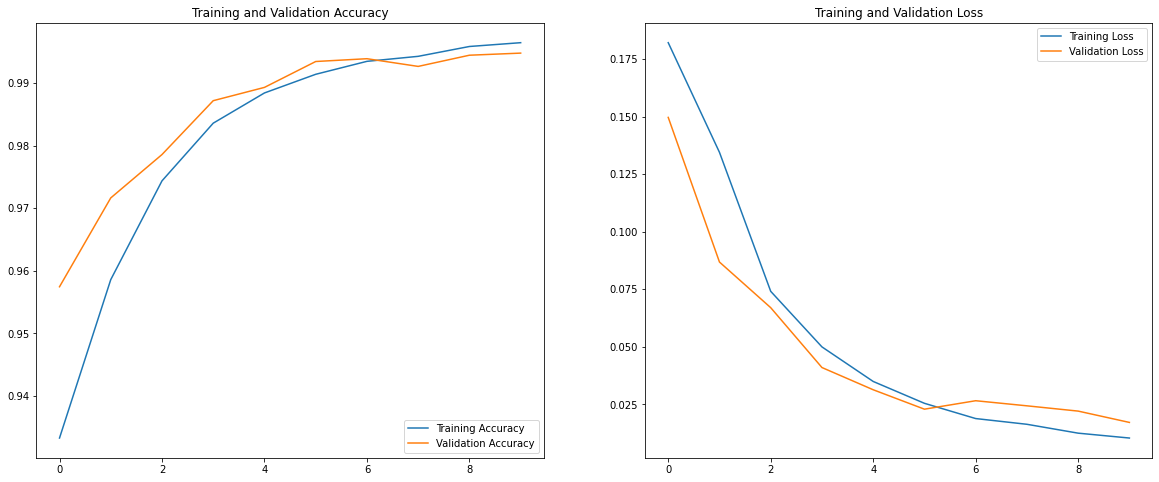

In [30]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [31]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

560/560 [==============================] - 59s 105ms/step - loss: 0.0171 - accuracy: 0.9948
val loss, val acc: [0.017147541046142578, 0.9947521090507507]


In [32]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


7/7 [==============================] - 1s 132ms/step - loss: 0.0016 - accuracy: 1.0000
test loss, test acc: [0.0016420132014900446, 1.0]
